<div align=center><h1 style="display: inline;" >4. Word Embeddings (B1)</h1><img style="display: inline;" src=http://industrypulse.com/wp-content/uploads/2017/05/h2oai-1068x1068.png width=100></div>

word2vec is an algorithm for representing words in a vector space. Words that occur in similar contexts are mapped to nearby vectors in the space — these vectors can then be used in subsequent numerical algorithms.

The efficacy of word2vec is based upon the distributional hypothesis in linguistics, which contends that words used in similar contexts convey similar meanings. By measuring the contexts that words appear in, word2vec can hopefully create a vector space where words are (to some extent) sorted by meaning.

word2vec works by training a neural network. The inputs of the neural network represent words, and the hidden layer represents the n-dimensional space that they will be embedded in. The network is trained on nearby words, and in this way the network learns weights between the word-space and the vector-space such that words appearing in similar contexts are mapped to nearby vectors.  The two main training methods are "skip-grams" and "continuous bag of words."

# 4.1 Importing and Cleaning Data

In [1]:
library(h2o)
h2o.init(nthreads = -1)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         19 minutes 29 seconds 
    H2O cluster version:        3.14.0.6 
    H2O cluster version age:    9 days  
    H2O cluster name:           ec2-user 
    H2O cluster total nodes:    2 
    H2O cluster total memory:   1.46 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.4.1 (2017-06-30) 



In [2]:
lending.hex = h2o.importFile("hdfs://ec2-34-204-73-232.compute-1.amazonaws.com:9000/LoanStats_2017Q1.csv")

  |======================================================================| 100%


In [3]:
lending.hex = lending.hex[lending.hex['annual_inc'] < 200000,]

# 4.2 Word2Vec

** Change type of 'emp_title':**

In [4]:
h2o.ischaracter(lending.hex['emp_title'])

[1] FALSE

In [5]:
lending.hex['emp_title'] = as.character(lending.hex['emp_title'])
h2o.ischaracter(lending.hex['emp_title'])

[1] TRUE

**Tokenize the job titles to form a corpus for word2vec: **

In [6]:
tokens = h2o.tolower(h2o.tokenize(lending.hex['emp_title'], split="\\\\W+"))
tokens

           C1
1 maintenance
2   assistant
3        <NA>
4     project
5     manager
6        <NA>

[271523 rows x 1 column] 

** Create H2O word2vec model. ** There are a few important parameters to discuss here:
<table><p><td><b>Parameter</b></td><td><b>Explanation</b></td><td><b>Jobs Titles</b></td>
<tr><td>min_word_freq</td><td>words will be ignored if they do not pass this threshold</td><td>can be tuned</td></tr>
<tr><td>window_size</td><td>size of the context window for the Skip-Gram model to use around each word</td><td>vast majority under three words</td></tr>
<tr><td>vec_size</td><td>the dimensionality of the vector space that the words will be embedded in</td><td>can be tuned</td></tr>
<tr><td>sent_sample_rate</td><td>this is used for downsampling very common words (e.g. 'a','the','of')</td><td>unlikely to be useful</td></tr></table>

In [7]:
w2v.model <- h2o.word2vec(tokens, epochs = 10, min_word_freq = 5, vec_size = 50)

  |======================================================================| 100%


**Testing word2vec** ... sometimes it makes sense...

In [8]:
print(h2o.findSynonyms(w2v.model, "engineer", count = 5))

      synonym     score
1 engineering 0.6965685
2   architect 0.6637877
3   developer 0.6566272
4    designer 0.6348240
5      tester 0.6230693


... sometimes not so much...

In [9]:
print(h2o.findSynonyms(w2v.model, "lawyer", count = 5))

         synonym     score
1       employee 0.4177713
2      community 0.3760256
3 superintendent 0.3757597
4    facilitator 0.3704157
5          water 0.3557755


... other times it pairs words that occur in similar contexts but have opposite meanings (e.g. junior and senior):

In [11]:
print(h2o.findSynonyms(w2v.model, "senior", count = 5))

    synonym     score
1        sr 0.8608359
2       iii 0.7046552
3    junior 0.6333072
4        jr 0.6074410
5 principle 0.5708697


... nevertheless, it's better than random, so let's test it.

**Applying word2vec.** We transform the tokens to the vector space, and then cbind those vectors to the income values:

In [12]:
vecs <- h2o.transform(w2v.model, tokens, aggregate_method = 'AVERAGE')
reg <- h2o.cbind(lending.hex['annual_inc'], vecs)

# 4.3 Decision Trees and Random Forests

We now want to perform regression from the vector space to annual income. We expect this problem to be highly non-linear. Here we will look at methods based on decision-tree ensembles.

** Decision trees**

A decision tree is one of the simplest classification models. Decision trees work by forming a series of boundaries that attempt to maximally split the classes in question, as the following image illustrates:

<img src=http://image.slidesharecdn.com/lecture02ml4ltmarinasantini2013-130827052029-phpapp02/95/lecture-02-machine-learning-for-language-technology-decision-trees-and-nearest-neighbors-10-638.jpg?cb=1378716784 width=500>

Decision trees can be formed by a number of algorithms, most popular 'CART.' This works by testing all possible split points and taking a measure of how pure the resulting split is (e.g. the entropy). The classification case is generalized to regression by looking at the difference in regressand values on each side of the split. 

Taken alone, decision trees have a strong tendency to overfit, e.g.:

<img src=http://stephanie-w.github.io/brainscribble/figure/classification-algorithms-on-iris-dataset_48_0.png width=400>

However, when many (slightly different) decision trees are taken together as an <em>ensemble</em> we get some of the most powerful machine learning models known.

** Random forests**

Random forests are composed of many trees trained on the same data. Of course, the trees must differ in some way. This is done first by bootstrapping aggregating (or <em>bagging</em>). Here, each tree is trained on the same number of samples, but <em>with replacement</em>. Second, the trees may differ in the features they are trained on as well.

** Create and train an H2O random forest. ** There are a few important parameters to discuss here:
<table><p><td><b>Parameter</b></td><td><b>Explanation</b></td>
<tr><td>ntrees</td><td>The number of trees to ensemble</td></tr>
<tr><td>max_depth</td><td>The maximum number of splits for each tree</td></tr>
<tr><td>stopping_metric / stopping_rounds</td><td>If there is a validation set, then we can halt training (i.e. 'stop') if performance degrades. We can specify the metric upon which to base this decision, and the number of rounds to determine it</td></tr>
<tr><td>sample_rate</td><td>This allows random sampling of the training set for each tree</td></tr>
<tr><td>col_sample_rate_per_tree</td><td>This allows random sampling of the feature set for each tree</td></tr>
<tr><td>min_split_improvement</td><td>Don't make a split if it doesn't improve classification performance above this threshold. This is another method to prevent overfitting.</td></tr>
</table>

Normally we would tune these parameters for performance, but (other than some rough manual tuning) we will leave this topic until a subsequent section.

In [13]:
reg_split <- h2o.splitFrame(reg, ratios=c(0.8))

In [14]:
rfmodel <- h2o.randomForest(y='annual_inc', training_frame=h2o.na_omit(reg_split[[1]]), validation_frame=h2o.na_omit(reg_split[[2]]), ntrees=250)

  |======================================================================| 100%


**Evaluate the random forest:**

In [40]:
rfmodel@model$validation_metrics

H2ORegressionMetrics: drf
** Reported on validation data. **

MSE:  916779588
RMSE:  30278.37
MAE:  23138.74
RMSLE:  0.4395945
Mean Residual Deviance :  916779588


As a sanity check, let's check what these measures would be if we just estimated mean income for every job title:

In [41]:
print("RMSE:")
print(h2o.sqrt(h2o.mean((reg['annual_inc'] - h2o.mean(reg['annual_inc']))*(reg['annual_inc'] - h2o.mean(reg['annual_inc'])), na.rm=TRUE)))
print("MAE:")
print(h2o.mean(h2o.abs(reg['annual_inc'] - h2o.mean(reg['annual_inc'], na.rm=TRUE)), na.rm=TRUE))

[1] "RMSE:"
[1] 36066.96
[1] "MAE:"
[1] 28493.42


**Plotting a learning curve:**

In [16]:
learn_curve <- rfmodel@model$scoring_history[,c('number_of_trees','training_rmse','validation_rmse')]

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

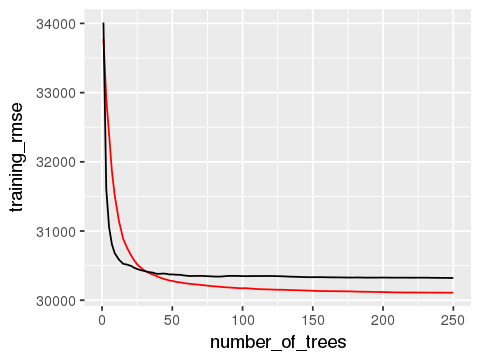

In [21]:
library(ggplot2)
library(repr)
options(repr.plot.width=4, repr.plot.height=3)
ggplot(data = learn_curve) + geom_path(mapping = aes(x = number_of_trees, y = training_rmse), color="red") + geom_path(mapping = aes(x = number_of_trees, y = validation_rmse))

# 4.4 Gradient Boosting: XGBoost

We will now compare an alternate method of ensembling decision trees: gradient boosting. Roughly, in this method, each tree is trained on the <em>error</em> (or residual) of the previous tree(s).

In recent years, the XGBoost instantiation of gradient boosting has garnered enormous attention. The differences between XGBoost and GBM are subtle, but XGBoost's regularization properties mean that it often outperforms other gradient boosting machines.

** Create and train an H2O XGBoost model. ** Here are a few of the parameters one can tune:
<table><p><td><b>Parameter</b></td><td><b>Explanation</b></td><td></td>
<tr><td>ntrees</td><td>same as random forest</td></tr>
<tr><td>max_depth</td><td>same as random forest</td></tr>
<tr><td>stopping_metric / stopping_rounds</td><td>same as random forest</td></tr>
<tr><td>eta</td><td>multiplicative factor to train each subsequent model; lower values give slower convergence</td></tr>
<tr><td>sample_rate</td><td>same as random forest</td></tr>
<tr><td>col_sample_rate_per_tree<td>same as random forest<td></td></tr>
</table>

Unfortunatley, H2O only supports XGBoost in single-node mode, so the following code will not run if the H2O cluster has both nodes up:

In [22]:
xgbmodel <- h2o.xgboost(y='annual_inc', training_frame=h2o.na_omit(reg_split[[1]]), validation_frame=h2o.na_omit(reg_split[[2]]), 
                        ntrees=100, max_depth=6, stopping_rounds=10, stopping_metric='RMSE')


ERROR: Unexpected HTTP Status code: 400 Bad Request (url = http://localhost:54321/3/ModelBuilders/xgboost)

java.lang.IllegalArgumentException
 [1] "java.lang.IllegalArgumentException: XGBoost is currently only supported in single-node mode."                
 [2] "    hex.tree.xgboost.XGBoost.init(XGBoost.java:377)"                                                         
 [3] "    water.api.ModelBuilderHandler.handle(ModelBuilderHandler.java:60)"                                       
 [4] "    water.api.ModelBuilderHandler.handle(ModelBuilderHandler.java:17)"                                       
 [5] "    water.api.RequestServer.serve(RequestServer.java:448)"                                                   
 [6] "    water.api.RequestServer.doGeneric(RequestServer.java:297)"                                               
 [7] "    water.api.RequestServer.doPost(RequestServer.java:223)"                                                  
 [8] "    javax.servlet.http.HttpServlet.ser

ERROR: Error in .h2o.doSafeREST(h2oRestApiVersion = h2oRestApiVersion, urlSuffix = page, : 

ERROR MESSAGE:

XGBoost is currently only supported in single-node mode.




In [45]:
xgbmodel@model

$cross_validation_models
NULL

$cross_validation_predictions
NULL

$cross_validation_holdout_predictions_frame_id
NULL

$cross_validation_fold_assignment_frame_id
NULL

$model_summary
Model Summary: 
  number_of_trees
1             100

$scoring_history
Scoring History: 
             timestamp   duration number_of_trees training_rmse training_mae
1  2017-10-19 18:57:03  0.120 sec               0   82780.39361  74514.21826
2  2017-10-19 18:57:05  1.973 sec               1   62254.76889  52254.97905
3  2017-10-19 18:57:06  2.789 sec               2   49029.49273  37760.60498
4  2017-10-19 18:57:07  3.451 sec               3   40883.53822  29799.97913
5  2017-10-19 18:57:07  4.227 sec               4   36125.66751  25977.62520
6  2017-10-19 18:57:12  8.443 sec              13   29815.21733  22913.43388
7  2017-10-19 18:57:16 12.533 sec              23   29236.52046  22521.44841
8  2017-10-19 18:57:20 16.728 sec              33   28980.02088  22309.29443
9  2017-10-19 18:57:24 20.771 sec  

In [49]:
xgbmodel@model$validation_metrics

H2ORegressionMetrics: xgboost
** Reported on validation data. **
** Metrics reported on validation frame **

MSE:  926876808
RMSE:  30444.65
MAE:  23293.82
RMSLE:  0.4415186
Mean Residual Deviance :  926876808


In [50]:
learn_curve <- xgbmodel@model$scoring_history[,c('number_of_trees','training_rmse','validation_rmse')]

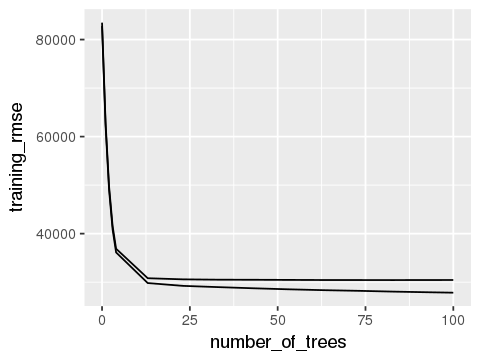

In [52]:
library(ggplot2)
library(repr)
options(repr.plot.width=4, repr.plot.height=3)
ggplot(data = learn_curve) + geom_path(mapping = aes(x = number_of_trees, y = training_rmse)) + geom_path(mapping = aes(x = number_of_trees, y = validation_rmse))

We could improve our model by tuning a number of hyperparameters, and subsequently by <em>ensembling</em>. We will refrain from doing that here, as we will be doing so in section 5.